<h1> Anomaly Detection [MLP Models and Auto-encoders]</h1>

<h2>Required Libraries</h2>

In [13]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.optimizers import Nadam
from keras.layers import LSTM
import math
from scipy.spatial import distance

<h2> Reading the anomalous and non anomalous data </h2>

In [4]:

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_real_ad2_url_suffix = "realAdExchange/exchange-2_cpm_results.csv"
df_real_ad2_url = master_url_root + df_real_ad2_url_suffix
df_real_ad2_url = pd.read_csv(df_real_ad2_url)

df_real_ad4_url_suffix = "realAdExchange/exchange-4_cpm_results.csv"
df_real_ad4_url = master_url_root + df_real_ad4_url_suffix
df_real_ad4_url = pd.read_csv(df_real_ad4_url)

<h2> Below is the dataframes' samples and its statistics </h2> 

In [5]:
df_real_ad2_url.head()

,timestamp,value
0,2011-07-01 00:00:01,0.401048
1,2011-07-01 01:00:01,0.392719
2,2011-07-01 02:00:01,0.309996
3,2011-07-01 03:00:01,0.212939
4,2011-07-01 04:00:01,0.205801


In [6]:
df_real_ad2_url.describe()

,value
count,1624.000000
mean,0.336523
std,0.162187
min,0.000385
25%,0.208210
50%,0.295056
75%,0.456151
max,1.051442


In [7]:
df_real_ad4_url.head()


,timestamp,value
0,2011-07-01 00:15:01,0.618226
1,2011-07-01 01:15:01,0.506628
2,2011-07-01 02:15:01,0.399551
3,2011-07-01 03:15:01,0.482681
4,2011-07-01 04:15:01,0.306038


In [8]:
df_real_ad4_url.describe()

,value
count,1643.000000
mean,0.533830
std,0.747022
min,0.121520
25%,0.360400
50%,0.467618
75%,0.583870
max,16.438200


In [14]:
def plot_dates_values(data,title):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.title(title)
    plt.ylabel("Value")
    plt.show()

<h2> Visualization of both datasets</h2>

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


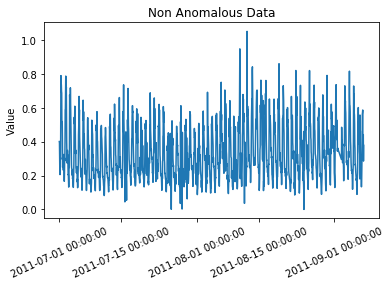

In [15]:
plot_dates_values(df_real_ad2_url,'Non Anomalous Data')

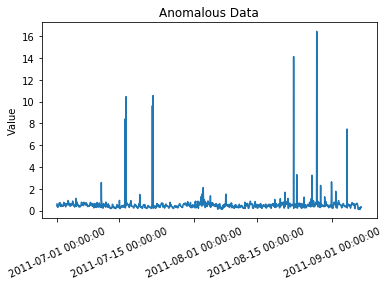

In [16]:
plot_dates_values(df_real_ad4_url,'Anomalous Data')

<p1> <br>Next, we write the below two functions to obtain the value column out of the dataframe and then normalizing the value column.</br></P1>

In [17]:
def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

training_value = get_value_from_df(df_real_ad2_url)
training_value, training_mean, training_std = normalize(training_value)


<p1> Following are the statistics of the normalized training data.</p1>

In [18]:
print('No of data points: '+str(len(training_value)) )
print('Mean of normalized training data: '+str(training_mean) )
print('Standard Deviation of normalized training data: '+str(training_std) )

No of data points: 1624
Mean of normalized training data: 0.33652251585485476
Standard Deviation of normalized training data: 0.16213702517719805


In [19]:
def transform(list_data, window,seq):
  X = list()
  y = list()
  for i in range(len(list_data)):
    last = i + window
    if last+seq > len(list_data)-1:
      break
    s_x = list_data[i:last]
    s_y = list_data[last:last+seq]
    X.append(s_x)
    y.append(s_y)
  return np.array(X),np.array(y)

<h2>Defining functions for metrics</h1>


In [20]:
def mae_loss(pred,true):
    train_mae_loss = np.mean(np.abs(pred - true), axis=1)

    plt.hist(train_mae_loss, bins=40)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.title("Histogram for train MAE Loss")
    plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)
    print("MAE threshold: ", threshold)
    return threshold

In [21]:
def sqr_loss(pred,true):
    train_sqr_loss = np.mean((pred**2 - true**2), axis=1)

    plt.hist(train_sqr_loss, bins=40)
    plt.xlabel("Train MSE loss")
    plt.ylabel("No of samples")
    plt.title("Histogram for train MSE Loss")
    
    plt.show()

# Get reconstruction loss threshold.
    threshold = np.max(train_sqr_loss)
    print("MSE threshold: ", threshold)
    return threshold

In [22]:
def euc(pred,true):
    error=list()
    for xv,yv in zip(pred,true):
        error.append(distance.euclidean(xv,yv))

    plt.hist(error, bins=40)
    plt.xlabel("Test Euclidean distance")
    plt.ylabel("No of samples")
    plt.title("Histogram for train Euclidean Distance")
    plt.show()

    # Get reconstruction loss threshold.
    threshold = np.max(error)
    print(" Euclidean Distance threshold: ", threshold)
    return threshold

<h2> Functions for plotting detected anomaly</h2>

In [23]:
def get_indices(TIME_STEPS,anomalies):
    anomalous_data_indices = []
    for data_idx in range(TIME_STEPS - 1, len(anomalies) - TIME_STEPS + 1):
        time_series = range(data_idx - TIME_STEPS + 1, data_idx)
        if all([anomalies[j] for j in time_series]):
            anomalous_data_indices.append(data_idx)
    return anomalous_data_indices

In [24]:
def plot_anomaly(anomalous_data_indices,title):
    df_subset = df_real_ad4_url.iloc[anomalous_data_indices, :]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)

    dates = df_real_ad4_url["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = df_real_ad4_url["value"].to_list()
    plt.plot(dates, values, label="test data")

    dates = df_subset["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = df_subset["value"].to_list()
    plt.plot(dates, values, label="anomalies", color="r")
    plt.title(title)
    plt.legend()
    plt.show()
    

<b>Setup-1</b>

In [25]:
x_data,y_data = transform(training_value,24,5)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=1)
print(len(x_train[0]))
print(len(y_train[0]))

24
5


In [26]:
model = Sequential()
model.add(Dense(24,activation='relu', input_dim=24))
model.add(Dense(5))
model.compile(optimizer='adam', loss='mse')
model_mlp1 = model.fit(x_train, y_train, epochs=100, verbose=1,validation_split=0.2,batch_size=32)

Train on 956 samples, validate on 240 samples
Epoch 1/100
956/956 [==============================] - 1s 659us/step - loss: 1.1901 - val_loss: 0.8524
Epoch 2/100
956/956 [==============================] - 0s 48us/step - loss: 0.7282 - val_loss: 0.5880
Epoch 3/100
956/956 [==============================] - 0s 46us/step - loss: 0.5265 - val_loss: 0.4591
Epoch 4/100
956/956 [==============================] - 0s 45us/step - loss: 0.4221 - val_loss: 0.3938
Epoch 5/100
956/956 [==============================] - 0s 45us/step - loss: 0.3677 - val_loss: 0.3565
Epoch 6/100
956/956 [==============================] - 0s 46us/step - loss: 0.3359 - val_loss: 0.3324
Epoch 7/100
956/956 [==============================] - 0s 45us/step - loss: 0.3147 - val_loss: 0.3164
Epoch 8/100
956/956 [==============================] - 0s 44us/step - loss: 0.3011 - val_loss: 0.3068
Epoch 9/100
956/956 [==============================] - 0s 45us/step - loss: 0.2906 - val_loss: 0.2987
Epoch 10/100
956/956 [=============

956/956 [==============================] - 0s 51us/step - loss: 0.1963 - val_loss: 0.2383
Epoch 81/100
956/956 [==============================] - 0s 52us/step - loss: 0.1957 - val_loss: 0.2389
Epoch 82/100
956/956 [==============================] - 0s 48us/step - loss: 0.1955 - val_loss: 0.2389
Epoch 83/100
956/956 [==============================] - 0s 46us/step - loss: 0.1958 - val_loss: 0.2385
Epoch 84/100
956/956 [==============================] - 0s 44us/step - loss: 0.1950 - val_loss: 0.2386
Epoch 85/100
956/956 [==============================] - 0s 42us/step - loss: 0.1952 - val_loss: 0.2375
Epoch 86/100
956/956 [==============================] - 0s 43us/step - loss: 0.1950 - val_loss: 0.2382
Epoch 87/100
956/956 [==============================] - 0s 44us/step - loss: 0.1947 - val_loss: 0.2369
Epoch 88/100
956/956 [==============================] - 0s 44us/step - loss: 0.1942 - val_loss: 0.2393
Epoch 89/100
956/956 [==============================] - 0s 44us/step - loss: 0.1940 - 

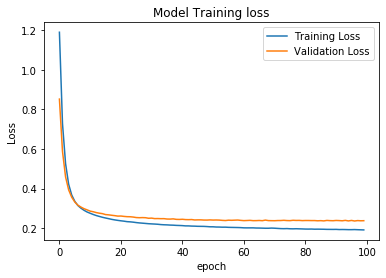

In [27]:
plt.figure()
plt.plot(model_mlp1.history['loss'])
plt.plot(model_mlp1.history['val_loss'])
plt.title('Model Training loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='best')

In [28]:
pred_mlp_1 = model.predict(x_test, verbose=0)
pred_mlp_1

array([[-1.2157614 , -1.1145431 , -0.8087732 , -0.5977901 , -0.03401937],
       [-0.9218306 , -0.76539826, -0.59798884, -0.5041195 , -0.19649932],
       [-0.9410588 , -1.1659322 , -1.2490484 , -1.4082167 , -1.2408621 ],
       ...,
       [ 2.3997943 ,  2.0151155 ,  1.5836846 ,  1.3580692 ,  0.75950325],
       [-0.1616544 , -0.2565779 , -0.37762314, -0.4729881 , -0.35974786],
       [ 0.7131258 ,  0.5013482 ,  0.00930969, -0.3037957 , -0.11561654]],
      dtype=float32)

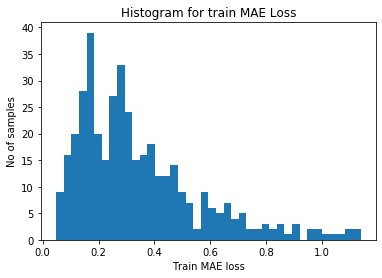

MAE threshold:  1.1379157356697835


In [29]:
th_mae=mae_loss(pred_mlp_1,y_test)

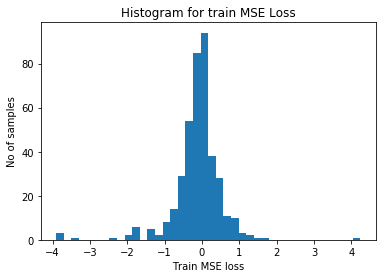

MSE threshold:  4.2411454270585836


In [30]:
th_sqr=sqr_loss(pred_mlp_1,y_test)

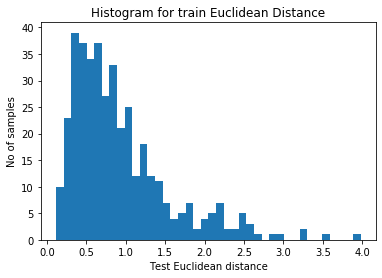

 Euclidean Distance threshold:  3.978507490147818


In [31]:
th_euc=euc(pred_mlp_1,y_test)

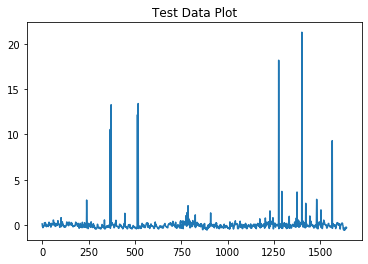

In [32]:
test_value = get_value_from_df(df_real_ad4_url)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
test_value, test_mean, test_std = normalize(test_value)
temp_list=test_value.tolist()

plt.plot(test_value)
plt.title("Test Data Plot")
plt.show()



<p1> Based on MAE LOSS </p2>

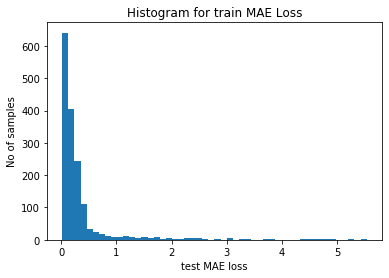

Number of anomaly samples:  107
Indices of anomaly samples:  (array([ 339,  340,  341,  342,  343,  344,  345,  346,  347,  348,  349,
        350,  355,  356,  360,  363,  364,  365,  366,  367,  368,  369,
        370,  371,  372,  486,  487,  488,  489,  490,  491,  492,  493,
        494,  495,  496,  497,  498,  500,  502,  503,  505,  506,  510,
        511,  513,  514,  515,  516,  517, 1248, 1249, 1250, 1251, 1252,
       1253, 1254, 1255, 1257, 1259, 1260, 1263, 1264, 1265, 1266, 1267,
       1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1373, 1374, 1375,
       1376, 1377, 1378, 1379, 1380, 1381, 1382, 1384, 1385, 1388, 1389,
       1391, 1394, 1396, 1397, 1398, 1399, 1400, 1401, 1454, 1455, 1456,
       1537, 1538, 1539, 1540, 1541, 1542, 1562, 1564]),)


In [33]:
x_data_test,y_data_test = transform(test_value,24,5)
# Get test MAE loss.
x_test_pred = model.predict(x_data_test)
test_mae_loss = np.mean(np.abs(x_test_pred - y_data_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.title("Histogram for train MAE Loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_mae_1 = (test_mae_loss > th_mae).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_mae_1))
print("Indices of anomaly samples: ", np.where(anomalies_mae_1))

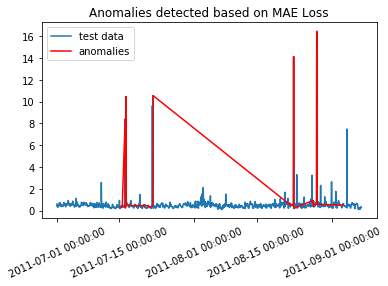

In [34]:
anomalous_data_indices_mae=get_indices(5,anomalies_mae_1)
plot_anomaly(anomalous_data_indices_mae,'Anomalies detected based on MAE Loss')

<p1> Based on Root mean square error</p2>

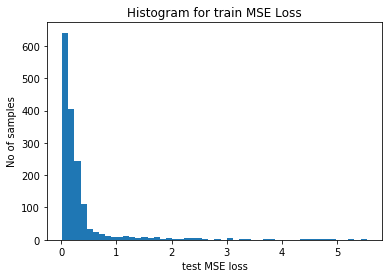

Number of anomaly samples:  11
Indices of anomaly samples:  (array([ 344,  490,  491,  495, 1253, 1373, 1374, 1375, 1376, 1377, 1378]),)


In [35]:
test_sqr_loss = np.mean((x_test_pred**2- y_data_test**2), axis=1)
test_sqr_loss = test_mae_loss.reshape((-1))

plt.hist(test_sqr_loss, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.title("Histogram for train MSE Loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_sqr_1 = (test_sqr_loss > th_sqr).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_sqr_1))
print("Indices of anomaly samples: ", np.where(anomalies_sqr_1))

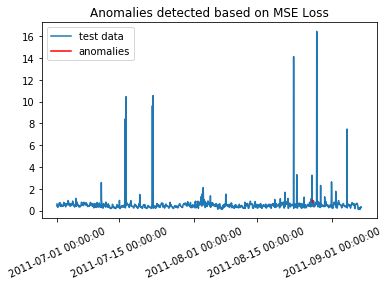

In [36]:
anomalous_data_indices_sqr=get_indices(5,anomalies_sqr_1)
plot_anomaly(anomalous_data_indices_sqr,'Anomalies detected based on MSE Loss')

<p1> Based on Euclidean Distance</p2>

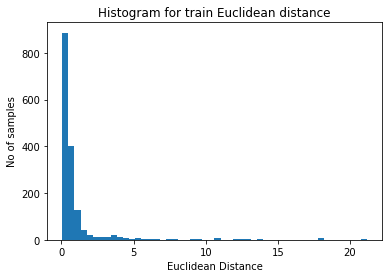

Number of anomaly samples:  11
Indices of anomaly samples:  (array([ 344,  490,  491,  495, 1253, 1373, 1374, 1375, 1376, 1377, 1378]),)


In [37]:
test_euc=list()
for xv,yv in zip(x_test_pred,y_data_test):
    test_euc.append(distance.euclidean(xv,yv))
#test_euc = test_euc.reshape((-1))

plt.hist(test_euc, bins=50)
plt.xlabel("Euclidean Distance")
plt.ylabel("No of samples")
plt.title("Histogram for train Euclidean distance")
plt.show()

# Detect all the samples which are anomalies.
anomalies_euc_1 = (test_sqr_loss > th_euc).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_euc_1))
print("Indices of anomaly samples: ", np.where(anomalies_euc_1))

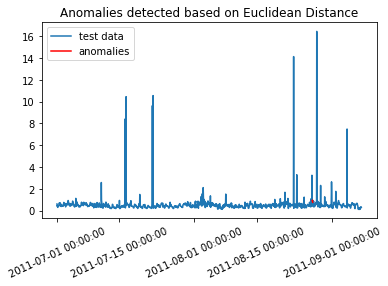

In [38]:
anomalous_data_indices_euc=get_indices(5,anomalies_euc_1)
plot_anomaly(anomalous_data_indices_euc,'Anomalies detected based on Euclidean Distance')

<h3>Setup-2</h3>

In [39]:
x_data,y_data = transform(training_value,10,5)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=1)
print(len(x_train[0]))
print(len(y_train[0]))

10
5


In [40]:
model = Sequential()
model.add(Dense(10,activation='relu', input_dim=10))
model.add(Dense(5))
model.compile(optimizer='adam', loss='mse')
model_mlp2 = model.fit(x_train, y_train, epochs=100, verbose=1,validation_split=0.2,batch_size=32)

Train on 964 samples, validate on 242 samples
Epoch 1/100
964/964 [==============================] - 1s 533us/step - loss: 1.1482 - val_loss: 1.1782
Epoch 2/100
964/964 [==============================] - 0s 48us/step - loss: 1.0053 - val_loss: 1.0789
Epoch 3/100
964/964 [==============================] - 0s 47us/step - loss: 0.9099 - val_loss: 1.0028
Epoch 4/100
964/964 [==============================] - 0s 43us/step - loss: 0.8286 - val_loss: 0.9321
Epoch 5/100
964/964 [==============================] - 0s 44us/step - loss: 0.7550 - val_loss: 0.8706
Epoch 6/100
964/964 [==============================] - 0s 44us/step - loss: 0.6880 - val_loss: 0.8132
Epoch 7/100
964/964 [==============================] - 0s 43us/step - loss: 0.6302 - val_loss: 0.7653
Epoch 8/100
964/964 [==============================] - 0s 44us/step - loss: 0.5835 - val_loss: 0.7299
Epoch 9/100
964/964 [==============================] - 0s 43us/step - loss: 0.5526 - val_loss: 0.7078
Epoch 10/100
964/964 [=============

964/964 [==============================] - 0s 44us/step - loss: 0.3807 - val_loss: 0.5474
Epoch 81/100
964/964 [==============================] - 0s 45us/step - loss: 0.3789 - val_loss: 0.5452
Epoch 82/100
964/964 [==============================] - 0s 45us/step - loss: 0.3784 - val_loss: 0.5450
Epoch 83/100
964/964 [==============================] - 0s 43us/step - loss: 0.3788 - val_loss: 0.5453
Epoch 84/100
964/964 [==============================] - 0s 44us/step - loss: 0.3772 - val_loss: 0.5446
Epoch 85/100
964/964 [==============================] - 0s 44us/step - loss: 0.3773 - val_loss: 0.5441
Epoch 86/100
964/964 [==============================] - 0s 44us/step - loss: 0.3762 - val_loss: 0.5434
Epoch 87/100
964/964 [==============================] - 0s 43us/step - loss: 0.3762 - val_loss: 0.5435
Epoch 88/100
964/964 [==============================] - 0s 46us/step - loss: 0.3759 - val_loss: 0.5437
Epoch 89/100
964/964 [==============================] - 0s 47us/step - loss: 0.3751 - 

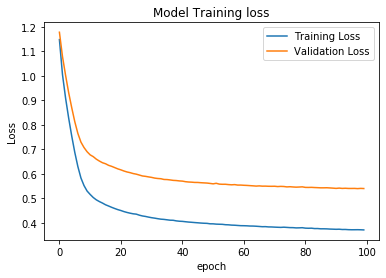

In [41]:
plt.figure()
plt.plot(model_mlp2.history['loss'])
plt.plot(model_mlp2.history['val_loss'])
plt.title('Model Training loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='best')

In [42]:
pred_mlp_2 = model.predict(x_test, verbose=0)
pred_mlp_2

array([[-0.7697011 , -0.8273796 , -0.5313448 , -0.50508887, -0.03924611],
       [-1.1705517 , -0.9685628 , -0.7933544 , -0.4293024 , -0.20329307],
       [-0.62906003, -0.05357324,  0.31694326,  0.7062321 ,  1.0667543 ],
       ...,
       [-0.5913236 , -0.70315176, -0.79453933, -0.07561798, -0.22965378],
       [-0.86275387, -0.4572959 , -0.07475379,  0.38569462,  0.7070411 ],
       [ 0.3279077 ,  0.32817394,  0.443526  ,  0.60799444,  0.44674802]],
      dtype=float32)

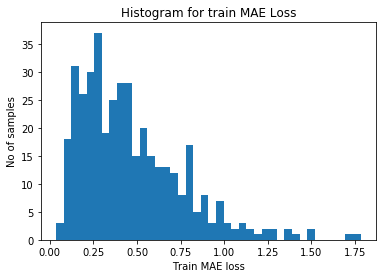

MAE threshold:  1.7820155309448904


In [43]:
th_mae=mae_loss(pred_mlp_2,y_test)

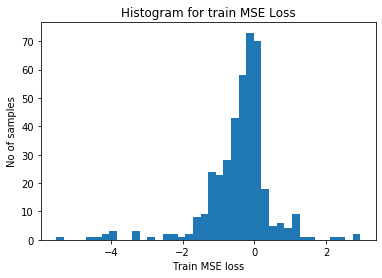

MSE threshold:  2.9546024451443906


In [44]:
th_sqr=sqr_loss(pred_mlp_2,y_test)

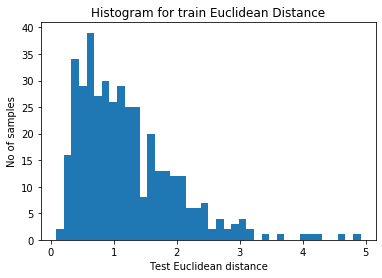

 Euclidean Distance threshold:  4.918510185035292


In [45]:
th_euc=euc(pred_mlp_2,y_test)

<p1>Based on MAE loss</p1>

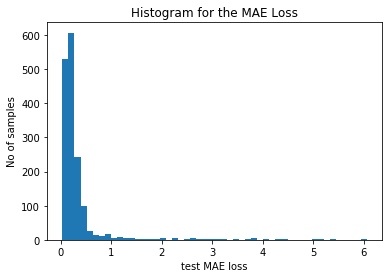

Number of anomaly samples:  47
Indices of anomaly samples:  (array([ 353,  354,  355,  356,  357,  358,  359,  360,  361,  362,  363,
        367,  372,  500,  501,  502,  503,  504,  505,  506,  507,  508,
        509,  514,  518, 1262, 1263, 1264, 1265, 1266, 1267, 1276, 1387,
       1388, 1389, 1390, 1391, 1392, 1394, 1401, 1551, 1552, 1553, 1554,
       1555, 1556, 1565]),)


In [46]:
x_data_test,y_data_test = transform(test_value,10,5)
# Get test MAE loss.
x_test_pred = model.predict(x_data_test)
test_mae_loss = np.mean(np.abs(x_test_pred - y_data_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.title("Histogram for the MAE Loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_mae_2 = (test_mae_loss > th_mae).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_mae_2))
print("Indices of anomaly samples: ", np.where(anomalies_mae_2))

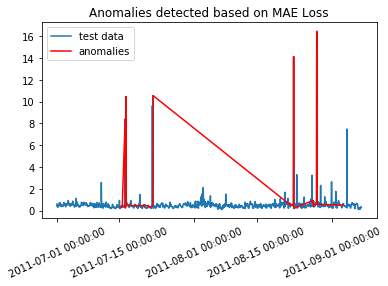

In [47]:
anomalous_data_indices_mae=get_indices(5,anomalies_mae_1)
plot_anomaly(anomalous_data_indices_mae,'Anomalies detected based on MAE Loss')

<p1> Based on MSE loss</p1>

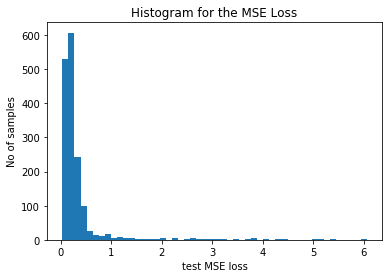

Number of anomaly samples:  27
Indices of anomaly samples:  (array([ 358,  360,  361,  362,  363,  372,  504,  505,  506,  507,  508,
        514, 1262, 1263, 1264, 1265, 1266, 1267, 1276, 1387, 1388, 1389,
       1390, 1391, 1392, 1401, 1556]),)


In [48]:
test_sqr_loss = np.mean((x_test_pred**2- y_data_test**2), axis=1)
test_sqr_loss = test_mae_loss.reshape((-1))

plt.hist(test_sqr_loss, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.title("Histogram for the MSE Loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_sqr_2 = (test_sqr_loss > th_sqr).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_sqr_2))
print("Indices of anomaly samples: ", np.where(anomalies_sqr_2))

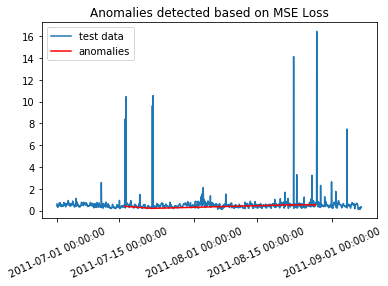

In [49]:
anomalous_data_indices_sqr=get_indices(5,anomalies_sqr_2)
plot_anomaly(anomalous_data_indices_sqr,'Anomalies detected based on MSE Loss')

<p1> Based on Euclidean Distance</p1>

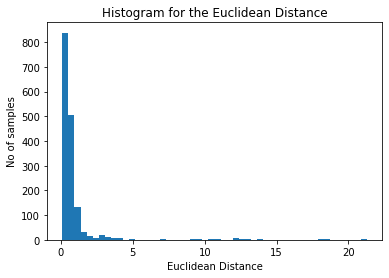

Number of anomaly samples:  6
Indices of anomaly samples:  (array([ 358,  504,  505, 1267, 1392, 1401]),)


In [50]:
test_euc=list()
for xv,yv in zip(x_test_pred,y_data_test):
    test_euc.append(distance.euclidean(xv,yv))
#test_euc = test_euc.reshape((-1))

plt.hist(test_euc, bins=50)
plt.xlabel("Euclidean Distance")
plt.ylabel("No of samples")
plt.title("Histogram for the Euclidean Distance")
plt.show()

# Detect all the samples which are anomalies.
anomalies_euc_2 = (test_sqr_loss > th_euc).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_euc_2))
print("Indices of anomaly samples: ", np.where(anomalies_euc_2))

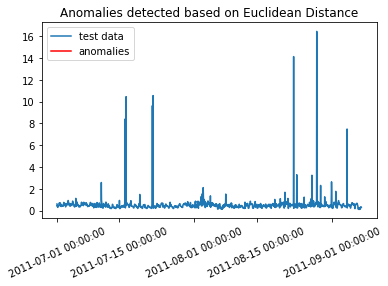

In [51]:
anomalous_data_indices_euc=get_indices(5,anomalies_euc_2)
plot_anomaly(anomalous_data_indices_euc,'Anomalies detected based on Euclidean Distance')

<h3>Setup-3</h3>

In [52]:
x_data,y_data = transform(training_value,5,5)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=1)
print(len(x_train[0]))
print(len(y_train[0]))

5
5


In [53]:
model = Sequential()
model.add(Dense(10,activation='relu', input_dim=5))
model.add(Dense(5))
model.compile(optimizer='adam', loss='mse')
model_mlp2 = model.fit(x_train, y_train, epochs=100, verbose=1,validation_split=0.2,batch_size=32)

Train on 968 samples, validate on 242 samples
Epoch 1/100
968/968 [==============================] - 1s 521us/step - loss: 1.8884 - val_loss: 1.4686
Epoch 2/100
968/968 [==============================] - 0s 45us/step - loss: 1.4917 - val_loss: 1.2198
Epoch 3/100
968/968 [==============================] - 0s 46us/step - loss: 1.2601 - val_loss: 1.0728
Epoch 4/100
968/968 [==============================] - 0s 44us/step - loss: 1.1255 - val_loss: 0.9715
Epoch 5/100
968/968 [==============================] - 0s 44us/step - loss: 1.0328 - val_loss: 0.9033
Epoch 6/100
968/968 [==============================] - 0s 46us/step - loss: 0.9683 - val_loss: 0.8500
Epoch 7/100
968/968 [==============================] - 0s 45us/step - loss: 0.9170 - val_loss: 0.8091
Epoch 8/100
968/968 [==============================] - 0s 45us/step - loss: 0.8735 - val_loss: 0.7722
Epoch 9/100
968/968 [==============================] - 0s 45us/step - loss: 0.8367 - val_loss: 0.7401
Epoch 10/100
968/968 [=============

968/968 [==============================] - 0s 42us/step - loss: 0.4480 - val_loss: 0.3833
Epoch 81/100
968/968 [==============================] - 0s 41us/step - loss: 0.4475 - val_loss: 0.3840
Epoch 82/100
968/968 [==============================] - 0s 41us/step - loss: 0.4463 - val_loss: 0.3817
Epoch 83/100
968/968 [==============================] - 0s 41us/step - loss: 0.4456 - val_loss: 0.3828
Epoch 84/100
968/968 [==============================] - 0s 41us/step - loss: 0.4448 - val_loss: 0.3793
Epoch 85/100
968/968 [==============================] - 0s 41us/step - loss: 0.4441 - val_loss: 0.3800
Epoch 86/100
968/968 [==============================] - 0s 41us/step - loss: 0.4441 - val_loss: 0.3803
Epoch 87/100
968/968 [==============================] - 0s 43us/step - loss: 0.4428 - val_loss: 0.3793
Epoch 88/100
968/968 [==============================] - 0s 41us/step - loss: 0.4414 - val_loss: 0.3776
Epoch 89/100
968/968 [==============================] - 0s 41us/step - loss: 0.4406 - 

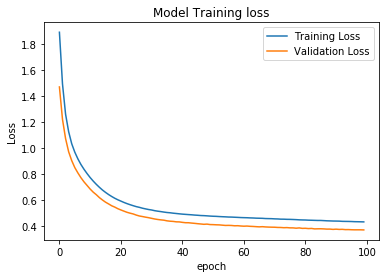

In [54]:
plt.figure()
plt.plot(model_mlp2.history['loss'])
plt.plot(model_mlp2.history['val_loss'])
plt.title('Model Training loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='best')

In [55]:
pred_mlp_3 = model.predict(x_test, verbose=0)
pred_mlp_3

array([[-0.02915895, -0.05696243, -0.16682842, -0.4368174 , -0.5517436 ],
       [-0.21300092, -0.24915087, -0.33132473, -0.54576063, -0.6327346 ],
       [-0.64028925, -0.78106517, -0.84501815, -0.7604963 , -0.63827056],
       ...,
       [-0.8274208 , -0.9440473 , -1.0957937 , -0.82591116, -0.674094  ],
       [ 0.7833243 ,  0.26080436,  0.0201202 , -0.0736118 , -0.2955799 ],
       [ 0.3054025 ,  0.28041294, -0.20209482, -0.55761266, -0.6518061 ]],
      dtype=float32)

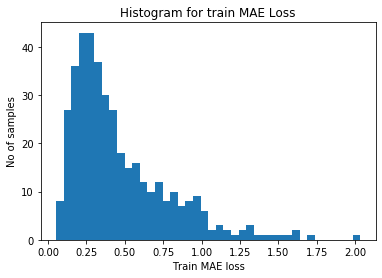

MAE threshold:  2.033876888915566


In [56]:
th_mae=mae_loss(pred_mlp_3,y_test)

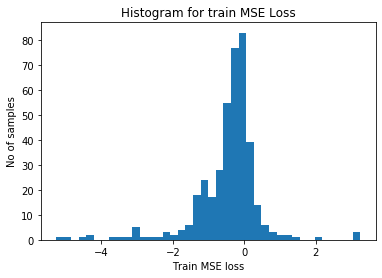

MSE threshold:  3.2506607624281307


In [57]:
th_sqr=sqr_loss(pred_mlp_3,y_test)

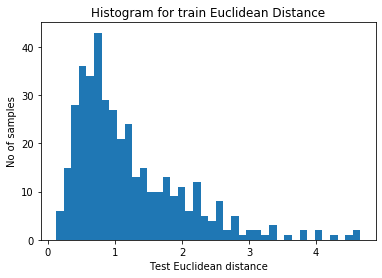

 Euclidean Distance threshold:  4.659875000495692


In [58]:
th_euc=euc(pred_mlp_3,y_test)

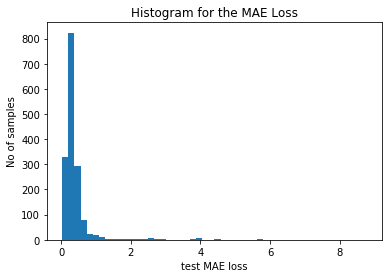

Number of anomaly samples:  42
Indices of anomaly samples:  (array([ 358,  359,  360,  361,  362,  363,  364,  365,  366,  367,  368,
        505,  506,  507,  508,  509,  510,  511,  512,  513, 1267, 1268,
       1269, 1270, 1271, 1272, 1273, 1275, 1392, 1393, 1394, 1395, 1396,
       1397, 1398, 1400, 1556, 1557, 1558, 1559, 1560, 1561]),)


In [59]:
x_data_test,y_data_test = transform(test_value,5,5)
# Get test MAE loss.
x_test_pred = model.predict(x_data_test)
test_mae_loss = np.mean(np.abs(x_test_pred - y_data_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.title("Histogram for the MAE Loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_mae_3 = (test_mae_loss > th_mae).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_mae_3))
print("Indices of anomaly samples: ", np.where(anomalies_mae_3))

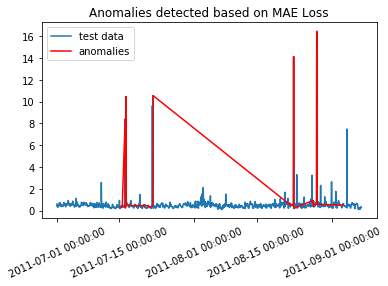

In [60]:
anomalous_data_indices_mae=get_indices(5,anomalies_mae_1)
plot_anomaly(anomalous_data_indices_mae,'Anomalies detected based on MAE Loss')

<p2> Based on MSE Loss</p2>

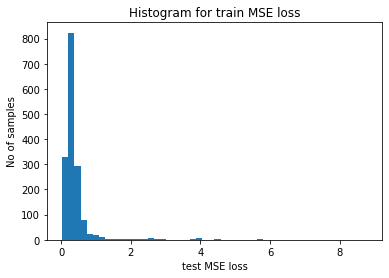

Number of anomaly samples:  22
Indices of anomaly samples:  (array([ 363,  364,  365,  366,  368,  509,  510,  511,  513, 1267, 1268,
       1269, 1270, 1271, 1272, 1392, 1393, 1394, 1395, 1396, 1397, 1561]),)


In [61]:
test_sqr_loss = np.mean((x_test_pred**2- y_data_test**2), axis=1)
test_sqr_loss = test_mae_loss.reshape((-1))

plt.hist(test_sqr_loss, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.title("Histogram for train MSE loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_sqr_3 = (test_sqr_loss > th_sqr).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_sqr_3))
print("Indices of anomaly samples: ", np.where(anomalies_sqr_3))

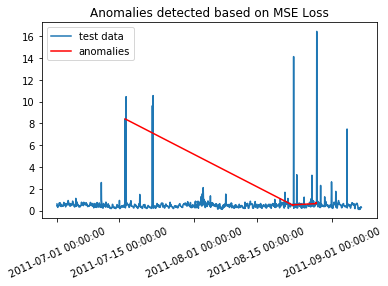

In [62]:
anomalous_data_indices_sqr=get_indices(5,anomalies_sqr_3)
plot_anomaly(anomalous_data_indices_sqr,'Anomalies detected based on MSE Loss')

<p1>Based on Euclidean distance</p2>

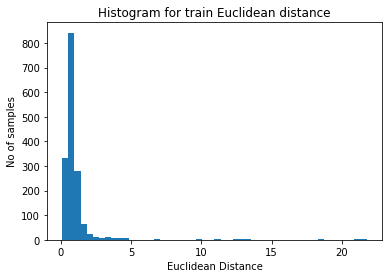

Number of anomaly samples:  6
Indices of anomaly samples:  (array([ 363,  368,  509,  510, 1272, 1397]),)


In [63]:
test_euc=list()
for xv,yv in zip(x_test_pred,y_data_test):
    test_euc.append(distance.euclidean(xv,yv))
#test_euc = test_euc.reshape((-1))

plt.hist(test_euc, bins=50)
plt.xlabel("Euclidean Distance")
plt.ylabel("No of samples")
plt.title("Histogram for train Euclidean distance")
plt.show()

# Detect all the samples which are anomalies.
anomalies_euc_3 = (test_sqr_loss > th_euc).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_euc_3))
print("Indices of anomaly samples: ", np.where(anomalies_euc_3))

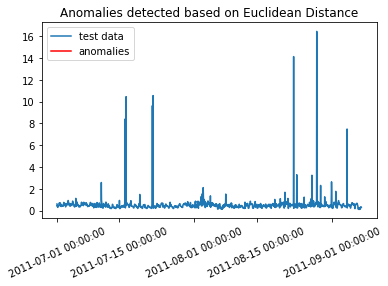

In [64]:
anomalous_data_indices_euc=get_indices(5,anomalies_euc_2)
plot_anomaly(anomalous_data_indices_euc,'Anomalies detected based on Euclidean Distance')

<h2> Using Auto Enocders </h2>

In [65]:
TIME_STEPS = 24


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.expand_dims(output, axis=2)
x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (1600, 24, 1)


<b>SETUP-1 LSTM</b>

In [66]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=32,input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=x_train.shape[1]))
model.add(keras.layers.LSTM(units=32, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
keras.layers.TimeDistributed(
keras.layers.Dense(units=x_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [67]:
history = model.fit(x_train, x_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

Train on 1440 samples, validate on 160 samples
Epoch 1/10
1440/1440 [==============================] - 8s 6ms/step - loss: 0.7967 - val_loss: 0.7494
Epoch 2/10
1440/1440 [==============================] - 4s 3ms/step - loss: 0.7066 - val_loss: 0.6437
Epoch 3/10
1440/1440 [==============================] - 6s 4ms/step - loss: 0.5668 - val_loss: 0.5276
Epoch 4/10
1440/1440 [==============================] - 3s 2ms/step - loss: 0.4491 - val_loss: 0.4634
Epoch 5/10
1440/1440 [==============================] - 4s 3ms/step - loss: 0.4090 - val_loss: 0.4343
Epoch 6/10
1440/1440 [==============================] - 4s 3ms/step - loss: 0.3884 - val_loss: 0.4162
Epoch 7/10
1440/1440 [==============================] - 4s 3ms/step - loss: 0.3755 - val_loss: 0.4186
Epoch 8/10
1440/1440 [==============================] - 4s 3ms/step - loss: 0.3622 - val_loss: 0.4109
Epoch 9/10
1440/1440 [==============================] - 4s 3ms/step - loss: 0.3614 - val_loss: 0.4055
Epoch 10/10
1440/1440 [============

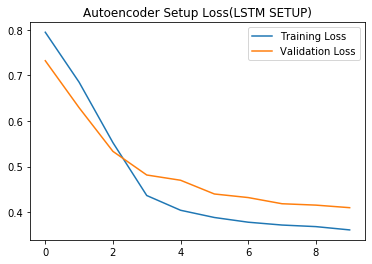

In [59]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Autoencoder Setup Loss(LSTM SETUP)")
plt.legend()

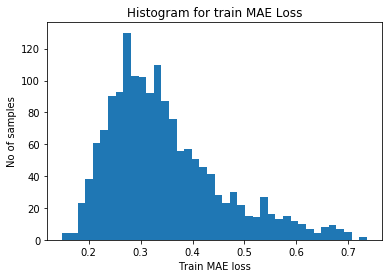

MAE threshold:  0.7357810715888659


In [60]:
x_train_pred = model.predict(x_train)
threshold_auto_1 = mae_loss(x_train_pred,x_train)

Test input shape:  (1619, 24, 1)


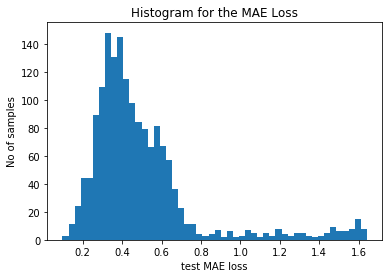

Number of anomaly samples:  156
Indices of anomaly samples:  (array([ 217,  236,  237,  238,  239,  240,  344,  345,  346,  347,  348,
        349,  350,  351,  352,  353,  354,  355,  356,  357,  358,  359,
        360,  361,  362,  363,  364,  365,  366,  367,  368,  369,  370,
        371,  372,  491,  492,  493,  494,  495,  496,  497,  498,  499,
        500,  501,  502,  503,  504,  505,  506,  507,  508,  509,  510,
        511,  512,  513,  514,  515,  516,  517,  518,  775,  776,  908,
        909, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262,
       1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273,
       1274, 1275, 1276, 1290, 1291, 1292, 1293, 1352, 1353, 1375, 1378,
       1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389,
       1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400,
       1401, 1420, 1421, 1422, 1459, 1476, 1477, 1478, 1479, 1480, 1481,
       1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1

In [61]:

x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.title("Histogram for the MAE Loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_auto_1 = (test_mae_loss > threshold_auto_1).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_auto_1))
print("Indices of anomaly samples: ", np.where(anomalies_auto_1))

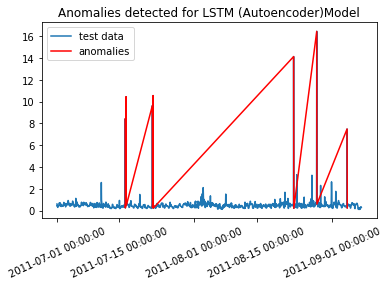

In [62]:
anomalous_data_indices_auto_1=get_indices(24,anomalies_auto_1)
plot_anomaly(anomalous_data_indices_auto_1,'Anomalies detected for LSTM (Autoencoder)Model')

<b>SETUP-2 Dense</b>

In [63]:
x_data,y_data = transform(training_value,24,5)

In [64]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D
from keras.models import Model
win=24
enc = 5
inp_win = Input(shape=(win,))

md = Dense(10, activation='relu')(inp_win)
en = Dense(enc, activation='relu')(md)
md = Dense(10, activation='relu')(en)
dec = Dense(win, activation='sigmoid')(md)
autoencoder = Model(inp_win, dec)
encoder = Model(inp_win, en)

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(x_data, x_data,
                epochs=50,
                batch_size=32,
                shuffle=False,
                validation_split=0.2)

pred_dense = autoencoder.predict(x_data)

Train on 1276 samples, validate on 319 samples
Epoch 1/50
1276/1276 [==============================] - 1s 626us/step - loss: 1.2780 - val_loss: 1.1067
Epoch 2/50
1276/1276 [==============================] - 0s 61us/step - loss: 1.2277 - val_loss: 1.0488
Epoch 3/50
1276/1276 [==============================] - 0s 61us/step - loss: 1.1385 - val_loss: 0.9778
Epoch 4/50
1276/1276 [==============================] - 0s 61us/step - loss: 1.0495 - val_loss: 0.9230
Epoch 5/50
1276/1276 [==============================] - 0s 61us/step - loss: 0.9787 - val_loss: 0.8778
Epoch 6/50
1276/1276 [==============================] - 0s 60us/step - loss: 0.9230 - val_loss: 0.8420
Epoch 7/50
1276/1276 [==============================] - 0s 60us/step - loss: 0.8803 - val_loss: 0.8066
Epoch 8/50
1276/1276 [==============================] - 0s 59us/step - loss: 0.8431 - val_loss: 0.7678
Epoch 9/50
1276/1276 [==============================] - 0s 61us/step - loss: 0.8035 - val_loss: 0.7184
Epoch 10/50
1276/1276 [==

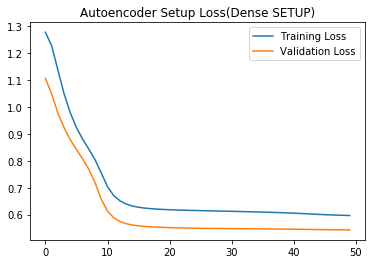

In [65]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Autoencoder Setup Loss(Dense SETUP)")
plt.legend()

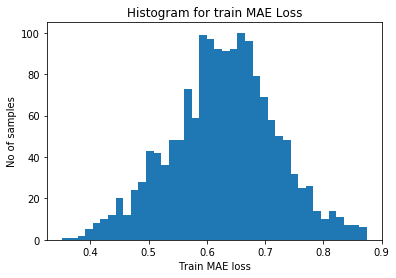

MAE threshold:  0.8742866820804108


In [66]:
x_data_pred = autoencoder.predict(x_data)
threshold_auto_2 = mae_loss(x_data_pred,x_data)

Test input shape:  (1614, 24)


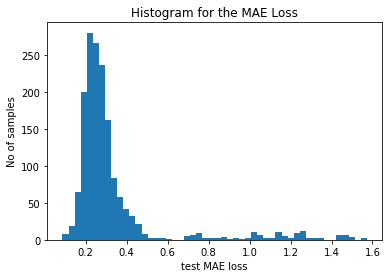

Number of anomaly samples:  98
Indices of anomaly samples:  (array([ 349,  350,  351,  352,  353,  354,  355,  356,  357,  358,  359,
        360,  361,  362,  363,  364,  365,  366,  367,  369,  370,  371,
        491,  492,  493,  494,  495,  496,  497,  498,  499,  500,  501,
        502,  503,  504,  505,  506,  507,  508,  509,  510,  511,  512,
        513,  514,  515,  516,  517,  518, 1253, 1254, 1255, 1256, 1257,
       1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268,
       1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1378, 1379, 1380,
       1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391,
       1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401]),)


In [67]:
x_test,_ = transform(test_value,24,5)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = autoencoder.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.title("Histogram for the MAE Loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_auto_2 = (test_mae_loss > threshold_auto_2).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_auto_2))
print("Indices of anomaly samples: ", np.where(anomalies_auto_2))

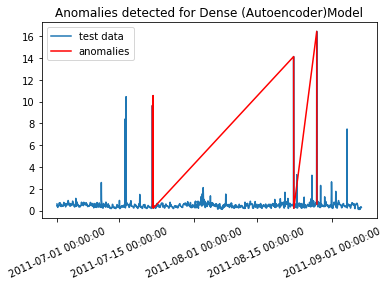

In [70]:
anomalous_data_indices_auto_2=get_indices(24,anomalies_auto_2)
plot_anomaly(anomalous_data_indices_auto_2,'Anomalies detected for Dense (Autoencoder)Model')

<b>SETUP-3 Dense(Simple Feed Forward)</b>

In [71]:
x_train_simple,_= transform(training_value,24,5)
inp_win = Input(shape=(win,))
en = Dense(enc, activation='relu')(inp_win)
dec = Dense(win, activation='sigmoid')(en)
autoencoder_sim = Model(inp_win, dec)
encoder = Model(inp_win, en)
autoencoder_sim.compile(optimizer='adam', loss='mse')
history = autoencoder_sim.fit(x_train_simple, x_train_simple,epochs=50,batch_size=32,shuffle=True,validation_split=0.1)

pred_sim = autoencoder_sim.predict(x_train_simple)

Train on 1435 samples, validate on 160 samples
Epoch 1/50
1435/1435 [==============================] - 1s 390us/step - loss: 1.2610 - val_loss: 1.0006
Epoch 2/50
1435/1435 [==============================] - 0s 46us/step - loss: 1.2091 - val_loss: 0.9663
Epoch 3/50
1435/1435 [==============================] - 0s 51us/step - loss: 1.1404 - val_loss: 0.9213
Epoch 4/50
1435/1435 [==============================] - 0s 42us/step - loss: 1.0574 - val_loss: 0.8656
Epoch 5/50
1435/1435 [==============================] - 0s 41us/step - loss: 0.9698 - val_loss: 0.8078
Epoch 6/50
1435/1435 [==============================] - 0s 42us/step - loss: 0.8909 - val_loss: 0.7550
Epoch 7/50
1435/1435 [==============================] - 0s 41us/step - loss: 0.8282 - val_loss: 0.7105
Epoch 8/50
1435/1435 [==============================] - 0s 41us/step - loss: 0.7795 - val_loss: 0.6733
Epoch 9/50
1435/1435 [==============================] - 0s 40us/step - loss: 0.7409 - val_loss: 0.6411
Epoch 10/50
1435/1435 [==

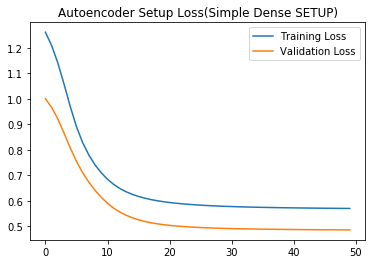

In [72]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Autoencoder Setup Loss(Simple Dense SETUP)")
plt.legend()

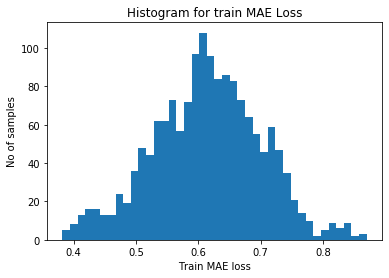

MAE threshold:  0.8703996173254479


In [73]:
x_data_pred = autoencoder_sim.predict(x_train_simple)
threshold_auto_3 = mae_loss(x_data_pred,x_train_simple)

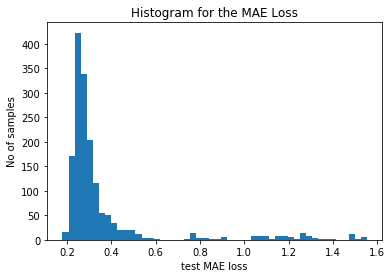

Number of anomaly samples:  102
Indices of anomaly samples:  (array([ 344,  345,  346,  349,  350,  351,  352,  353,  354,  355,  356,
        357,  358,  359,  360,  361,  362,  363,  364,  365,  366,  367,
        368,  370,  371,  372,  491,  492,  493,  494,  495,  496,  497,
        498,  499,  500,  501,  502,  503,  504,  505,  506,  507,  508,
        509,  510,  511,  512,  513,  514,  515,  516,  517,  518, 1253,
       1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264,
       1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275,
       1276, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387,
       1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398,
       1399, 1400, 1401]),)


In [74]:


# Get test MAE loss.
x_test_pred = autoencoder_sim.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.title("Histogram for the MAE Loss")
plt.show()

# Detect all the samples which are anomalies.
anomalies_auto_3 = (test_mae_loss > threshold_auto_3).tolist()
print("Number of anomaly samples: ", np.sum(anomalies_auto_3))
print("Indices of anomaly samples: ", np.where(anomalies_auto_3))

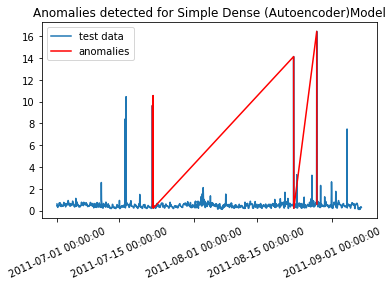

In [75]:
anomalous_data_indices_auto_3=get_indices(24,anomalies_auto_3)
plot_anomaly(anomalous_data_indices_auto_3,'Anomalies detected for Simple Dense (Autoencoder)Model')